In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import label_binarize
import warnings

warnings.filterwarnings('ignore')  # Suppress warnings

In [46]:
# Load data
df_white = pd.read_csv('winequality-white.csv', delimiter=';')
df_red = pd.read_csv('winequality-red.csv')

df = df_white #pd.concat([df_white, df_red])

# Create a quality label (low, medium, high) based on quality score
df['quality_label'] = df['quality'].apply(lambda x: 'Poor' if x < 5 else 'Average' if x <= 7 else 'High')

# Encode 'quality_label' to numerical values
label_enc = LabelEncoder()
df['quality_label'] = label_enc.fit_transform(df['quality_label'])

df = df.drop_duplicates()

# Separate features and target
X = df.drop(['quality', 'quality_label'], axis=1).to_numpy()
y = df['quality_label'].to_numpy()

In [47]:
# Define scaler and SMOTE
rb_scaler = RobustScaler()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
X_train = rb_scaler.fit_transform(X_train)
X_test = rb_scaler.transform(X_test)

In [48]:
# Define KNN model
knn = KNeighborsClassifier()

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Testing different k-values
    'weights': ['uniform', 'distance'],  # Distance-based or uniform weights
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Different distance metrics
}

# Run GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters and train the best model
print(f"Best Parameters: {grid_search.best_params_}")
best_knn = grid_search.best_estimator_

# Predictions
y_pred = best_knn.predict(X_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


In [49]:
accuracy = accuracy_score(y_test, best_knn.predict(X_test))
print(f'Accuracy: {accuracy*100:.2f} %')

Accuracy: 92.26 %


In [50]:
# Evaluation Metrics
print('\nEncoded Quality Labels:', dict(zip(label_enc.classes_, label_enc.transform(label_enc.classes_))))
print('\n', classification_report(y_test, y_pred))


Encoded Quality Labels: {'Average': 0, 'High': 1, 'Poor': 2}

               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1097
           1       0.50      0.05      0.10        37
           2       0.50      0.05      0.10        55

    accuracy                           0.92      1189
   macro avg       0.64      0.37      0.39      1189
weighted avg       0.89      0.92      0.89      1189



In [51]:
# Cross-validation scores
cv_scores = cross_val_score(best_knn, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.92612613 0.92612613 0.92057762 0.92779783 0.92960289]
Mean cross-validation score: 0.9260461183204866


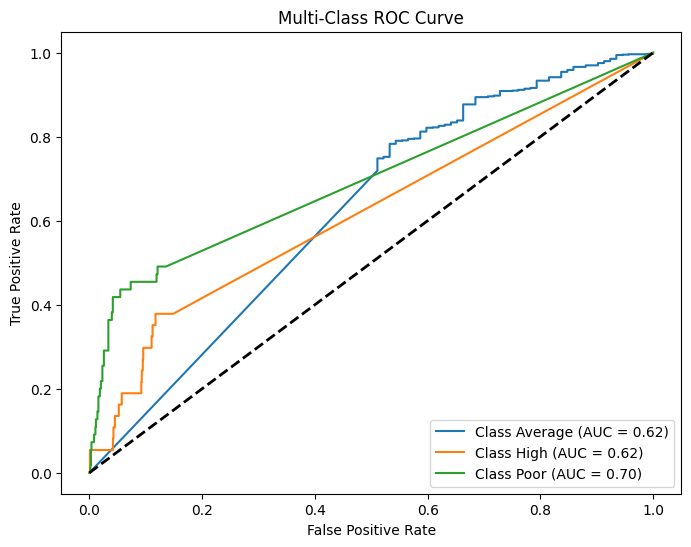

In [52]:
# Convert y_test and y_pred to binary format for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # One-hot encode labels
y_score = best_knn.predict_proba(X_test)  # Get probability scores for each class

# Number of classes
n_classes = y_test_bin.shape[1]

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_enc.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

# Random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Plot formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


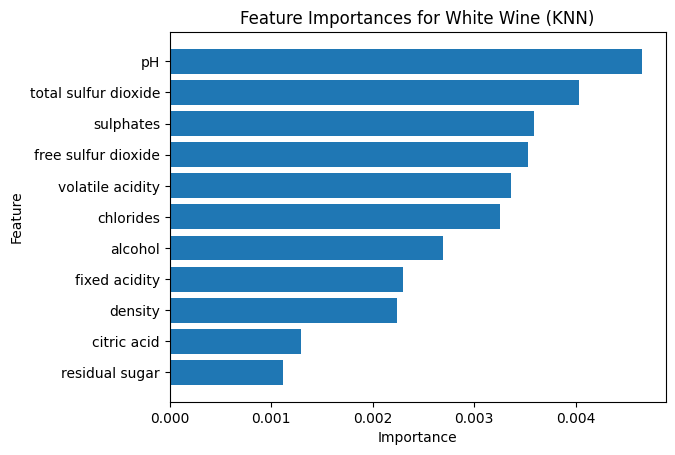

In [53]:
feature_names = df.drop(['quality', 'quality_label'], axis=1).columns

perm_importance = permutation_importance(best_knn, X_test, y_test, n_repeats=15, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plot = plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Feature Importances for White Wine (KNN)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()